In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from Scripts.data_processing import DataManager
from Scripts.model_analysis import ModelEvaluator
from Scripts.models import Valuer, Recommender, train_evaluation_system, train_generative_system

from pathlib import Path
import pickle

import torch

from typing import Tuple
import matplotlib.pyplot as plt
import numpy as np

In [3]:
torch.cuda.is_available()
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [4]:
DATA_PATH = 'dados/dados_treino.csv'
manager = DataManager(DATA_PATH)
print(manager.users)

OUTPUT_PATH = 'dados/modelos'

['#ID4940', '#ID9181']


### __Treinamento do sistema ajustado por usuário.__

O sistema deve treinar e ajustar um modelo para cada usuário. O modelo treinado será salvo em uma pasta.

In [5]:
models = []

for USER in manager.users:
    print(f"Training models for user {USER}")
    
    # 1. Treina os modelos de classificação e regressão.
    
    # Aqui os modelos serão especificados manualmente, mas eles poderiam ser escolhidos utilizado os scripts
    # do sistema de avaliação de modelos.
    print('Training classification and regression models.')
    classifier, regressor = train_evaluation_system(manager, USER)
    evaluator_model = Valuer(classification_model = classifier, regression_model = regressor)
    
    # 2. Treina o modelo generativo.
    print('Training generative model.')
    
    skorch_model, scaler = train_generative_system(manager, USER, verbose = False)
    models.append(skorch_model) # para gerar as curvas de aprendizado
    generative_model = skorch_model.module_
    
    # 3. Criação do sistema de recomendação adaptado ao usuário
    
    print("Creating recommender model.")
    recommender = Recommender(generativeModel = generative_model,
                              evaluationModel = evaluator_model,
                              scaler = scaler,
                              user = USER)
    print()
    
    # 4. Salva o modelo
    
    path = Path(OUTPUT_PATH) / USER
    path.mkdir(parents = True, exist_ok = True)
    
    print(f"Saving recommender model to: {path}")
    filehandler = open(path / 'recommender.pickle', "wb")
    pickle.dump(recommender, filehandler)
    
    print(f"Finishing model adjusment for user {USER}")
    print()

Training models for user #ID4940
Training classification and regression models.
Classifier Model: DecisionTreeClassifier()
Accuracy Score: 0.6131386861313869

Regression Model: LinearRegression()
Mean Squared Error: 2.416730036971711

Training generative model.
Generative Model:
<class 'skorch.net.NeuralNet'>[uninitialized](
  module=<class 'Scripts.models.VariationalAutoencoder'>,
  module__hidden_dims=[40],
  module__latent_dim=35,
)

Creating recommender model.

Saving recommender model to: dados/modelos/#ID4940
Finishing model adjusment for user #ID4940

Training models for user #ID9181
Training classification and regression models.
Classifier Model: DecisionTreeClassifier()
Accuracy Score: 0.8

Regression Model: LinearRegression()
Mean Squared Error: 2.203294609993449

Training generative model.
Generative Model:
<class 'skorch.net.NeuralNet'>[uninitialized](
  module=<class 'Scripts.models.VariationalAutoencoder'>,
  module__hidden_dims=[40],
  module__latent_dim=35,
)

Creating 

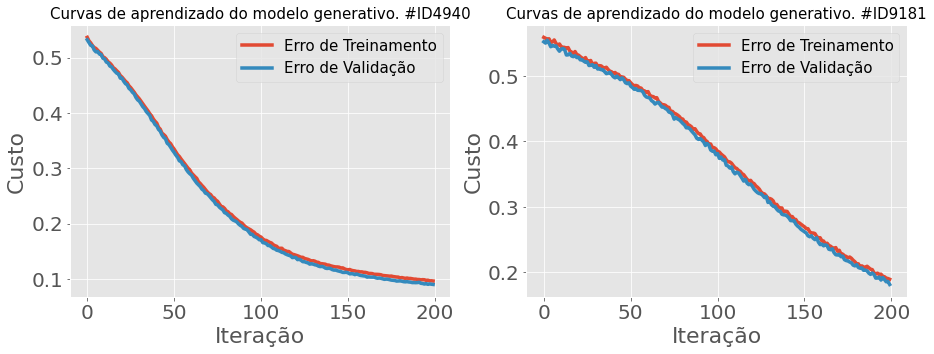

In [6]:
plt.style.use('ggplot')
fig, axs = plt.subplots(ncols = 2, figsize = (15, 5))

train_loss = models[0].history[:, 'train_loss']
valid_loss = models[0].history[:, 'valid_loss']
X = range(len(train_loss))

axs[0].plot(X, train_loss, label = 'Erro de Treinamento', linewidth = 3.5)
axs[0].plot(X, valid_loss, label = 'Erro de Validação', linewidth = 3.5)

axs[0].set_ylabel("Custo", fontsize = 22)
axs[0].set_xlabel("Iteração", fontsize = 22)
axs[0].set_title(f"Curvas de aprendizado do modelo generativo. {manager.users[0]}", fontsize = 15)
axs[0].tick_params(axis='both', which='major', labelsize=20)

axs[0].legend(fontsize = 15)

train_loss = models[1].history[:, 'train_loss']
valid_loss = models[1].history[:, 'valid_loss']
X = range(len(train_loss))

axs[1].plot(X, train_loss, label = 'Erro de Treinamento', linewidth = 3.5)
axs[1].plot(X, valid_loss, label = 'Erro de Validação', linewidth = 3.5)

axs[1].set_ylabel("Custo", fontsize = 22)
axs[1].set_xlabel("Iteração", fontsize = 22)
axs[1].set_title(f"Curvas de aprendizado do modelo generativo. {manager.users[1]}", fontsize = 15)
axs[1].tick_params(axis='both', which='major', labelsize=20)

axs[1].legend(fontsize = 15)

fig.savefig("curvas_aprendizado_autoencoder.png", bbox_inches = 'tight')

### __Teste do sistema generativo carregado da memória após o ajuste.__

In [7]:
USER = manager.users[0]
model_path = Path(OUTPUT_PATH) / manager.users[0] / 'recommender.pickle'
file = open(model_path, "rb")
recommender = pickle.load(file)

In [8]:
recommendation_list = recommender.getMusicList(20, manager.data.drop(columns = ['id_cliente', 'data_curtida', 'n_reproducao', 'gostou']))

In [9]:
recommendation_list.drop_duplicates()

,Tem_Instr_Violao_Viola,Tem_Instr_Guitarra,Tem_Instr_Cavaco,Tem_Instr_Sintetizador_Teclado,Tem_Instr_Piano,Tem_Instr_Metais,Tem_Instr_Madeiras,Tem_Instr_Cordas,escala_maior,bateria_eletronica,...,f#,g,g#,ano_lancamento,BPM,VolMedio,PctCantada,PctRap,duracao,evaluation
3187,0,1,0,0,1,0,0,1,0,0,...,0,0,0,1932,122.645038,7.576540,0.477790,0.000000,8.176367,"(1.0, 3.975738525390625)"
4091,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1985,95.646560,12.924551,0.766802,0.000000,4.731233,"(1.0, 3.912689208984375)"
616,1,1,0,1,0,0,0,0,1,0,...,0,0,0,1948,99.290248,6.558549,0.738328,0.000000,4.577033,"(1.0, 3.7176513671875)"
1345,0,1,0,0,1,1,0,1,1,0,...,0,0,0,1983,113.480079,9.839040,0.385652,0.000000,5.975167,"(1.0, 3.68804931640625)"
2027,0,1,0,0,0,0,0,0,1,0,...,0,0,0,1969,68.381821,10.636310,0.666510,0.000000,3.655683,"(1.0, 3.65179443359375)"
2518,1,0,1,0,0,0,0,0,0,0,...,0,1,0,2021,110.771105,12.654357,0.798548,0.000000,4.413117,"(1.0, 3.306427001953125)"
1313,1,1,0,1,0,0,0,0,1,0,...,0,0,0,1975,162.971887,12.837623,0.641352,0.000000,3.380717,"(1.0, 3.265411376953125)"
1451,1,0,0,1,0,0,0,0,1,0,...,0,0,0,2021,140.424738,7.865828,0.756684,0.143969,4.110650,"(1.0, 3.15826416015625)"
3223,1,1,0,1,0,0,0,0,0,0,...,0,0,0,2004,144.158981,5.744865,0.752736,0.160553,4.371217,"(1.0, 3.1029052734375)"
3651,0,0,0,1,1,0,0,0,1,1,...,0,0,0,2021,159.605388,6.397082,0.603864,0.193095,2.245517,"(1.0, 3.007904052734375)"


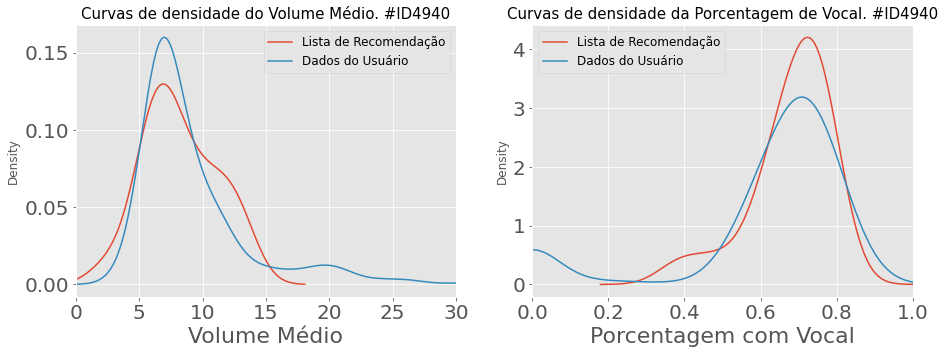

In [36]:
fig, ax = plt.subplots(ncols = 2, figsize = (15, 5))

user_data_liked = manager.user_data(USER)
user_data_liked = user_data_liked[user_data_liked['gostou'] == 1]

recommendation_list['VolMedio'].plot.density(ax = ax[0], label = 'Lista de Recomendação')
user_data_liked['VolMedio'].plot.density(ax = ax[0], label = 'Dados do Usuário')

recommendation_list['PctCantada'].plot.density(ax = ax[1], label = 'Lista de Recomendação')
user_data_liked['PctCantada'].plot.density(ax = ax[1], label = 'Dados do Usuário')

ax[0].legend(fontsize = 12)
ax[1].legend(fontsize = 12)

ax[0].set_xlabel("Volume Médio", fontsize = 22)
ax[1].set_xlabel("Porcentagem com Vocal", fontsize = 22)
ax[0].set_xlim([0, 30.0])
ax[1].set_xlim([0, 1.0])

ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=20)

ax[0].set_title(f"Curvas de densidade do Volume Médio. {manager.users[0]}", fontsize = 15)
ax[1].set_title(f"Curvas de densidade da Porcentagem de Vocal. {manager.users[0]}", fontsize = 15)

fig.savefig("densidades_lista_recomendacao.png", bbox_inches = 'tight')

### __Avaliação do desempenho do sistema.__

In [29]:
USER = manager.users[0]
model_path = Path(OUTPUT_PATH) / manager.users[0] / 'recommender.pickle'
file = open(model_path, "rb")
recommender = pickle.load(file)

classification_errors = []
regression_errors = []

for iteration in range(500):
    a, b = recommender.test_model(manager.user_data(USER))
    classification_errors.append(a)
    regression_errors.append(b)

In [30]:
np.array(classification_errors).mean(), np.array(classification_errors).std()

(0.8549000000000001, 0.08585446988945887)

In [31]:
np.array(regression_errors).mean(), np.array(regression_errors).std()

(2.977444515009318, 1.1519412378164413)

In [32]:
USER = manager.users[1]
model_path = Path(OUTPUT_PATH) / manager.users[1] / 'recommender.pickle'
file = open(model_path, "rb")
recommender = pickle.load(file)

classification_errors = []
regression_errors = []

for iteration in range(500):
    a, b = recommender.test_model(manager.user_data(USER))
    classification_errors.append(a)
    regression_errors.append(b)

In [33]:
np.array(classification_errors).mean(), np.array(classification_errors).std()

(0.9374999999999999, 0.05584576975922168)

In [34]:
np.array(regression_errors).mean(), np.array(regression_errors).std()

(3.751582725895912, 1.1824962908272618)